## Cloudless Mosaic

This tutorial constructs a *cloudless mosaic* (also known as a composite) from a time series of satellite images. We'll see the following:

* Find a time series of images at a particular point on Earth
* Stack those images together into a single array
* Compute the cloudless mosaic by taking a median
* Visualize the results

This example uses [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data. The techniques used here apply equally well to other remote-sensing datasets.

In [ ]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from dask_gateway import GatewayCluster

### Create a Dask cluster

We're going to process a large amount of data. To cut down on the execution time, we'll use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [ ]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

### Discover data

In this example, we define our area of interest as a GeoJSON object. It's near Redmond, Washington.

In [3]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.27508544921875, 47.54687159892238],
            [-121.96128845214844, 47.54687159892238],
            [-121.96128845214844, 47.745787772920934],
            [-122.27508544921875, 47.745787772920934],
            [-122.27508544921875, 47.54687159892238],
        ]
    ],
}

bbox = rasterio.features.bounds(area_of_interest)

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

In [48]:
stac = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = stac.search(
    bbox=bbox,
    datetime="2024-06-01/2024-12-31",
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 25}},
)

items = search.item_collection()
print(len(items))

21


In [49]:
items

So 138 items match our search requirements, over space, time, and cloudiness. Those items will still have *some* clouds over portions of the scenes, though. To create our cloudless mosaic, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then reduce the time-series of images down to a single image.

In [50]:
data = (
    stackstac.stack(
        items,
        assets=["B04", "B03", "B02"],  # red, green, blue
        chunksize=4096,
        resolution=100,
        epsg=32610
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)
data

<xarray.DataArray 'stackstac-adbc0ebf0ab81dc5738f99949f49ce88' (time: 21,
                                                                band: 3,
                                                                y: 1119, x: 1120)> Size: 632MB
dask.array<where, shape=(21, 3, 1119, 1120), dtype=float64, chunksize=(1, 1, 1119, 1120), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 168B 2024-...
    id                                       (time) <U54 5kB 'S2A_MSIL2A_2024...
  * x                                        (x) float64 9kB 4.999e+05 ... 6....
  * y                                        (y) float64 9kB 5.301e+06 ... 5....
    s2:generation_time                       (time) <U27 2kB '2024-06-06T03:1...
    s2:water_percentage                      (time) float64 168B 11.37 ... 12.28
    ...                                       ...
    proj:transform                           object 8B {0.0, 5300040.0, 10.0,...
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32610
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499900, 5189200, 611900, 5301...
    crs:         epsg:32610
    transform:   | 100.00, 0.00, 499900.00|\n| 0.00,-100.00, 5301100.00|\n| 0...
    resolution:  100

Since the data matching our query isn't too large we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [51]:
data = data.persist()

/home/lmizzoni/.local/share/hatch/env/virtual/cloudless-mosaic/_zrtjEu2/cloudless-mosaic/lib/python3.12/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


In [52]:
data

<xarray.DataArray 'stackstac-adbc0ebf0ab81dc5738f99949f49ce88' (time: 21,
                                                                band: 3,
                                                                y: 1119, x: 1120)> Size: 632MB
dask.array<where, shape=(21, 3, 1119, 1120), dtype=float64, chunksize=(1, 1, 1119, 1120), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 168B 2024-...
    id                                       (time) <U54 5kB 'S2A_MSIL2A_2024...
  * x                                        (x) float64 9kB 4.999e+05 ... 6....
  * y                                        (y) float64 9kB 5.301e+06 ... 5....
    s2:generation_time                       (time) <U27 2kB '2024-06-06T03:1...
    s2:water_percentage                      (time) float64 168B 11.37 ... 12.28
    ...                                       ...
    proj:transform                           object 8B {0.0, 5300040.0, 10.0,...
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32610
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499900, 5189200, 611900, 5301...
    crs:         epsg:32610
    transform:   | 100.00, 0.00, 499900.00|\n| 0.00,-100.00, 5301100.00|\n| 0...
    resolution:  100

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are transient, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images.

This will be computed in parallel on the cluster (make sure to open the Dask Dashboard using the link printed out above).

In [53]:
median = data.median(dim="time").compute()

In [54]:
median

<xarray.DataArray 'stackstac-adbc0ebf0ab81dc5738f99949f49ce88' (band: 3,
                                                                y: 1119, x: 1120)> Size: 30MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates: (12/19)
  * x                                        (x) float64 9kB 4.999e+05 ... 6....
  * y                                        (y) float64 9kB 5.301e+06 ... 5....
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    proj:code                                <U10 40B 'EPSG:32610'
    instruments                              <U3 12B 'msi'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    ...                                       ...
    proj:transform                           object 8B {0.0, 5300040.0, 10.0,...
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32610
  * band                                     (band) <U5 60B 'red' 'green' 'blue'

To visualize the data, we'll use xarray-spatial's `true_color` method to convert to red/green/blue values.

In [55]:
image = ms.true_color(*median)  # expects red, green, blue DataArrays

In [56]:
image

<xarray.DataArray 'true_color' (y: 1119, x: 1120, band: 4)> Size: 5MB
array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)
Coordinates:
  * y        (y) float64 9kB 5.301e+06 5.301e+06 ... 5.189e+06 5.189e+06
  * x        (x) float64 9kB 4.999e+05 5e+05 5.001e+05 ... 6.117e+05 6.118e+05
  * band     (band) int64 32B 0 1 2 3

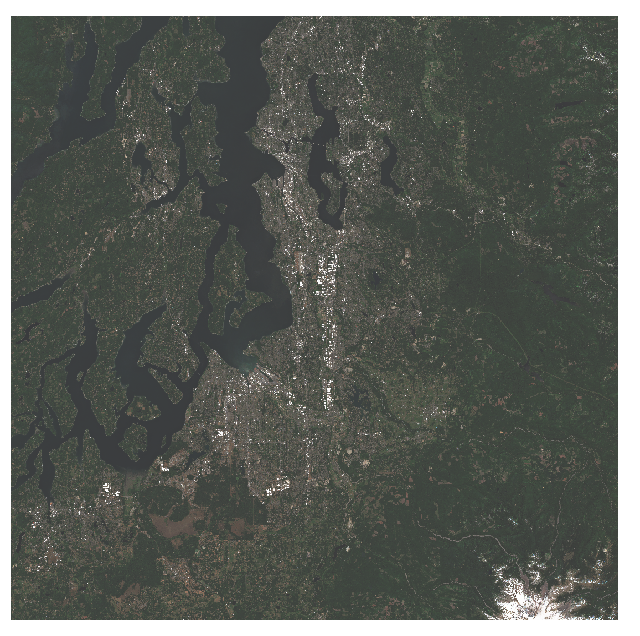

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

ax.set_axis_off()
image.plot.imshow(ax=ax);

### Monthly composite

Now suppose we don't want to combine images from different parts of the year (for example, we might not want to combine images from January that often include snow with images from July). Again using standard xarray syntax, we can create set of per-month composites by grouping by month and then taking the median.

In [58]:
monthly = data.groupby("time.month").median().compute()

In [59]:
monthly

<xarray.DataArray 'stackstac-adbc0ebf0ab81dc5738f99949f49ce88' (month: 6,
                                                                band: 3,
                                                                y: 1119, x: 1120)> Size: 180MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates: (12/20)
  * x                                        (x) float64 9kB 4.999e+05 ... 6....
  * y                                        (y) float64 9kB 5.301e+06 ... 5....
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    proj:code                                <U10 40B 'EPSG:32610'
    instruments                              <U3 12B 'msi'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    ...                                       ...
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32610
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * month                                    (month) int64 48B 6 7 8 9 10 11
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499900, 5189200, 611900, 5301...
    crs:         epsg:32610
    transform:   | 100.00, 0.00, 499900.00|\n| 0.00,-100.00, 5301100.00|\n| 0...
    resolution:  100

Let's convert each of those arrays to a true-color image and plot the results as a grid.

In [60]:
images = [ms.true_color(*x) for x in monthly]
images = xr.concat(images, dim="time")

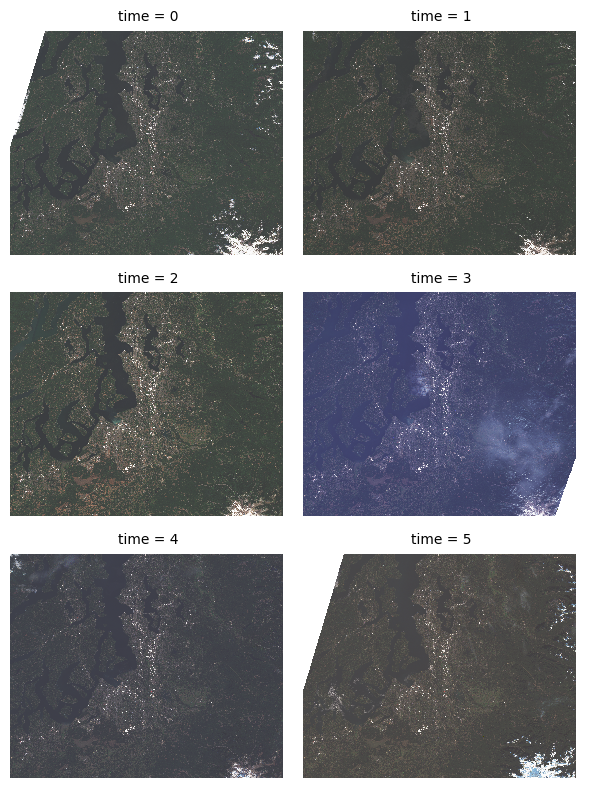

In [63]:
g = images.plot.imshow(x="x", y="y", rgb="band", col="time", col_wrap=2, figsize=(6, 8))
for ax in g.axs.flat:
    ax.set_axis_off()

plt.tight_layout()

### Learn more

To learn more about using the the Planetary Computer's STAC API, see [Reading data from the STAC API](../quickstarts/reading-stac.ipynb). To learn more about Dask, see [Scaling with Dask](../quickstarts/scale-with-dask.ipynb).